# **BSP Project: ECG signal decomposition using Fourier analysis**

*   **Author:** Matteo Onger
*   **Date:** February 2025

**Documentation**:
*   Paper: [ECG signal decomposition using Fourier analysis](https://doi.org/10.1186/s13634-024-01171-x)
*   Dataset: ...

**Notes**:
*   ...

In [39]:
# ---- LIBRARIES ----
import importlib
import matplotlib.pyplot as plt
import numpy as np
import logging
import os


# set logger
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(name)s:%(funcName)s - %(message)s", level=logging.DEBUG, force=True)
logger = logging.getLogger(__name__)


# current runtime type, if gpu available use cupy else numpy
if os.environ["COLAB_GPU"] != "":
    GPU = True
    logger.info("GPU connected")
    logger.info("Load Cupy")
    ncp = importlib.import_module("cupy")
else:
    GPU = False
    logger.info("No accelerator connected")
    ncp = np

2025-01-21 10:01:32,077 | INFO | __main__:<cell line: 0> - No accelerator connected


In [43]:
# ---- FUNCTIONS ----
def dft_l1(x :ncp.ndarray, K :int, max_iters :int=5, eps :float|None=1e-6) -> ncp.ndarray:
    """
    Computes the l1 Fourier transform of a real signal ``x`` and returns the Fourier coefficients.
    The parameter ``K`` determines the number of Fourier coefficients to compute, so,
    if it is not equal to the length of ``x``, a truncated l1 Fourier trasform is computed.

    Parameters
    ----------
    x : numpy.ndarray | cupy.ndarray of shape \(N)
        Original signal, i.e. an array of ``N`` real numbers that are the samples collected.
    K : int
        Number of Fourier coefficients to compute.
    max_iters : int, optional
        Maximum number of iterations, by default is ``5``.
    eps : float | None, optional
        Tolerance for the convergence of the algorithm, by default is ``1e-6``.
        If ``None``, the algorithm will run until the maximum number of iterations is reached.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(K)
        The Fourier coefficients computed, i.e. an array of ``K`` complex numbers.

    Raises
    ------
    : ValueError
        If ``K != N`` and ``K > 1 + N//2``.

    Notes
    -----
    - If the input signal ``x`` contains complex numbers, only the real part is taken into account.
    """
    N = len(x)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("<K> must be equal to the length of <x> or smaller/equal than half the length of <x> plus 1")

    logger.info(f"Start -> K={K}, max_iters={max_iters}, eps={eps}")

    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # keep only real part
    x = ncp.real(x)

    # total number of coefficients computed
    # including complex conjugates
    M = 2*K - 1 if K != N else K
    if (N % 2 == 0) and (K == 1 + N//2):
        M -= 1

    # fourier basis, matrix of shape (N,M) and its conjugate transpose
    fi = ncp.exp(ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K-M, K, 1)] for n in range(N)])) / ncp.sqrt(N)
    tconj_fi = ncp.transpose(ncp.conj(fi))

    # init fourier coefficients
    coeff = ncp.ones(fi.shape[1], dtype=ncp.complex128)
    # reconstructed signal
    xk = ncp.real(fi @ coeff)
    # previously recon. signal
    prev_xk = None

    for iter in range(max_iters):
        #delta = ncp.diag(1 / ncp.abs(x - xk))
        delta = ncp.abs(x - xk)
        delta = ncp.diag(1 / ncp.where(delta == 0, 1e-18, delta))

        # update fourier coefficients and prev. recon. signal and recon. signal
        coeff = ncp.linalg.inv(tconj_fi @ delta @ fi) @ tconj_fi @ delta @ x
        prev_xk = xk
        xk = ncp.real(fi @ coeff)

        # check convergency
        conv = np.mean(np.abs(xk - prev_xk))
        logger.debug(f"Iteration {iter+1} -> convergency={conv}")
        if (eps is not None) and (conv <= eps):
            break

    # compute final convergency and loss wrt original signal
    conv, loss = np.mean(np.abs(xk - prev_xk)), ncp.abs((x - xk) / np.where(x == 0, 1, x))
    logger.info(f"End -> iter={iter}, " +
        f"convergency={ncp.round(conv, 4)}, " +
        f"min_abs_loss={ncp.around(ncp.min(loss), 4)}, "  +
        f"avg_abs_loss={ncp.around(ncp.mean(loss), 4)}, " +
        f"max_abs_loss={ncp.around(ncp.max(loss), 4)}"
    )
    return ncp.asnumpy(coeff[-K:]) if GPU and isnumpy else coeff[-K:]


def idft_l1(coeff :ncp.ndarray, N :int, onlyreal :bool=False) -> ncp.ndarray:
    """
    Computes the inverse l1 Fourier transform of a real signal ``x`` given its Fourier coefficients ``coeff``
    and returns the reconstructed signal.

    Parameters
    ----------
    coeff : numpy.ndarray | cupy.ndarray of shape \(K)
        Fourier coefficients, i.e. an array of ``K`` complex numbers.
    N : int
        Length of the signal to reconstruct.
    onlyreal : bool, optional
        If ``True``, only the real part of the reconstructed signal is returned, by default is ``False``.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(N)
        The reconstructed signal, i.e. an array of ``N`` real numbers.

    Raises
    ------
    : ValueError
        If ``K != N`` and ``K > 1 + N//2``.
    """
    K = len(coeff)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("the number of coefficients must be equal to <N> or smaller/equal than <N> half plus 1")

    # if gpu available, move data to the device
    isnumpy = isinstance(coeff, np.ndarray)
    if GPU and isnumpy:
        coeff = ncp.asarray(coeff)

    # total number of coefficients computed
    # including complex conjugates
    M = 2*K - 1 if K != N else K
    if (N % 2 == 0) and (K == 1 + N//2):
        M -= 1

    # fourier basis, matrix of shape (N,M)
    fi = ncp.exp(ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K-M, K, 1)] for n in range(N)])) / ncp.sqrt(N)

    # if not given, compute conjugate fourier coefficients
    if N != K:
        if (N % 2 == 0) and (K == 1 + N//2):
            coeff = ncp.concatenate((ncp.conj(coeff[1:-1][::-1]), coeff))
        else:
            coeff = ncp.concatenate((ncp.conj(coeff[1:][::-1]), coeff))

    # reconstructed signal
    xk = ncp.real(fi @ coeff) if onlyreal else fi @ coeff
    return ncp.asnumpy(xk) if GPU and isnumpy else xk

2025-01-21 10:02:08,818 | INFO | __main__:dft_l1 - Start -> K=6, max_iters=10, eps=1
2025-01-21 10:02:08,867 | DEBUG | __main__:dft_l1 - Iteration 1 -> convergency=0.5859377266101876
2025-01-21 10:02:08,873 | INFO | __main__:dft_l1 - End -> iter=0, convergency=0.5859, min_abs_loss=0.0, avg_abs_loss=0.1176, max_abs_loss=0.8738


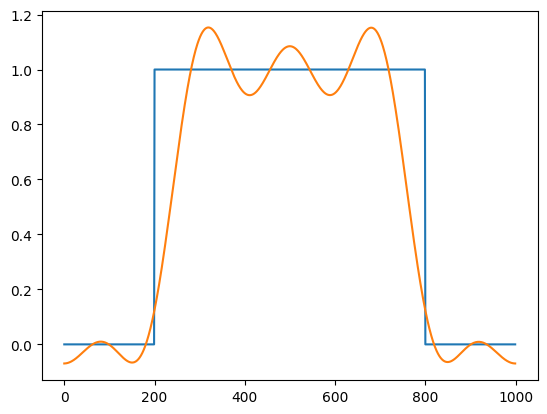

In [42]:
N = 1000

t = np.arange(N)
x = np.array([0] * 200 + [1] * 600 + [0] * 200)

c = dft_l1(x, K=6, max_iters=10, eps=1)
xk = idft_l1(c, N=N, onlyreal=True)

plt.plot(t, x)
plt.plot(t, xk)
plt.show()

## An example:

2025-01-21 10:01:00,602 | INFO | __main__:dft_l1 - Start -> K=1000, max_iters=5, eps=1e-06
2025-01-21 10:01:03,807 | INFO | __main__:dft_l1 - End -> iter=1, convergency=0.0, min_abs_loss=0.0, avg_abs_loss=0.0, max_abs_loss=0.0
2025-01-21 10:01:03,811 | INFO | __main__:dft_l1 - Start -> K=501, max_iters=5, eps=1e-06
2025-01-21 10:01:07,025 | INFO | __main__:dft_l1 - End -> iter=1, convergency=0.0, min_abs_loss=0.0, avg_abs_loss=0.0, max_abs_loss=0.0
2025-01-21 10:01:07,027 | INFO | __main__:dft_l1 - Start -> K=10, max_iters=5, eps=1e-06
2025-01-21 10:01:07,178 | INFO | __main__:dft_l1 - End -> iter=4, convergency=0.0011, min_abs_loss=0.0093, avg_abs_loss=1.7675, max_abs_loss=189.0797


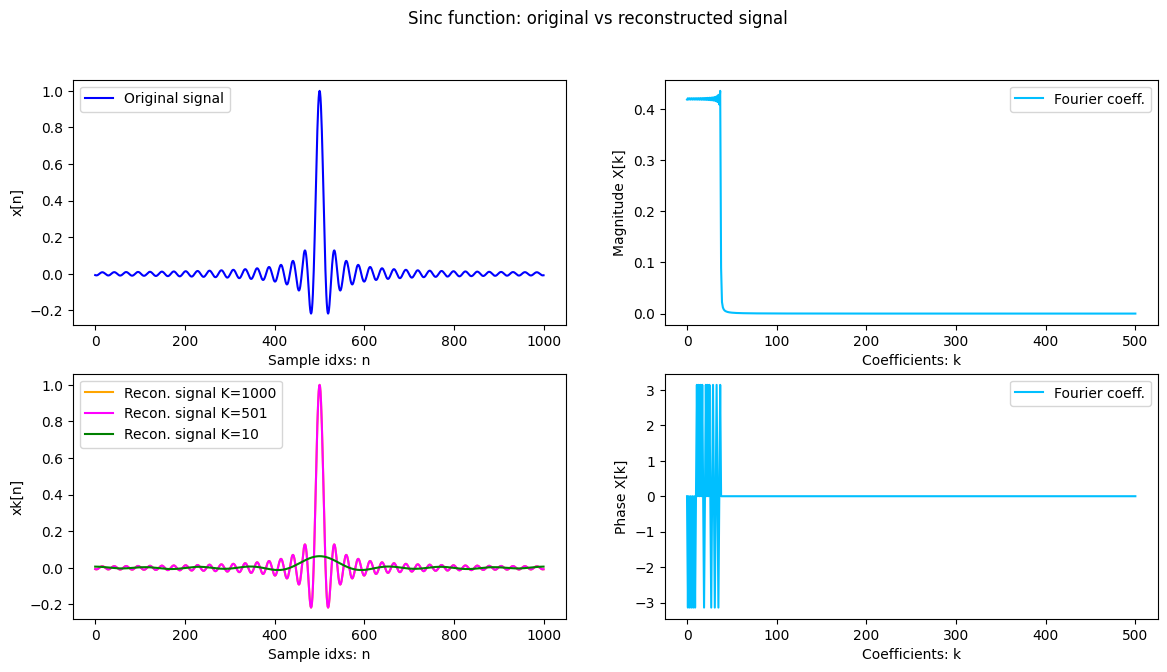

In [38]:
# frequency
f = 12
# number of samples
N = 1000

# original signal
n = np.arange(N)
x = np.sinc(2 * np.pi * f * np.linspace(-0.5, 0.5, N, endpoint=False))

# compute dft and reconstruct the signal
c1 = dft_l1(x, K=1000)
c2 = dft_l1(x, K=501)
c3 = dft_l1(x, K=10)

xk1 = idft_l1(c1, N=N, onlyreal=True)
xk2 = idft_l1(c2, N=N, onlyreal=True)
xk3 = idft_l1(c3, N=N, onlyreal=True)

# plot the results
fig, axs = plt.subplots(2, 2, figsize=(14, 7))
fig.suptitle("Sinc function: original vs reconstructed signal")

axs[0, 0].plot(n, x, c="blue", label="Original signal")
axs[0, 0].set(xlabel="Sample idxs: n", ylabel="x[n]")
axs[0, 0].legend(loc="upper left")

axs[1, 0].plot(n, np.real(xk1), c="orange", label="Recon. signal K=1000")
axs[1, 0].plot(n, np.real(xk2), c="magenta", label="Recon. signal K=501")
axs[1, 0].plot(n, np.real(xk3), c="green", label="Recon. signal K=10")
axs[1, 0].set(xlabel="Sample idxs: n", ylabel="xk[n]")
axs[1, 0].legend(loc="upper left")

axs[0, 1].plot(n[:501], np.abs(c1[:501]), c="deepskyblue", label="Fourier coeff.")
axs[0, 1].set(xlabel="Coefficients: k", ylabel="Magnitude X[k]")
axs[0, 1].legend(loc="upper right")

axs[1, 1].plot(n[:501], np.angle(c1[:501]), c="deepskyblue", label="Fourier coeff.")
axs[1, 1].set(xlabel="Coefficients: k", ylabel="Phase X[k]")
axs[1, 1].legend(loc="upper right")

plt.show()

## ...

In [19]:
a = 0
b = None
for i in range(1, 11):
    b, a = a, i
    print(a, b)

1 0
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8
10 9
